In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import skimage
from scipy.ndimage.measurements import histogram
from skimage.filters.rank import entropy
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.morphology import disk
import impavi 

# Image Segmentation techniques ( 3/3 )

This last problem is a very interesting one involving very poor lighting conditions. I will apply very specific filters and transformations that will manage to perform the segmentation improving the SSIM. As you can see in the image below, **segmentation can not be performed based on color (or gray-scale value)** so I will have to find other properties that vary between regions.

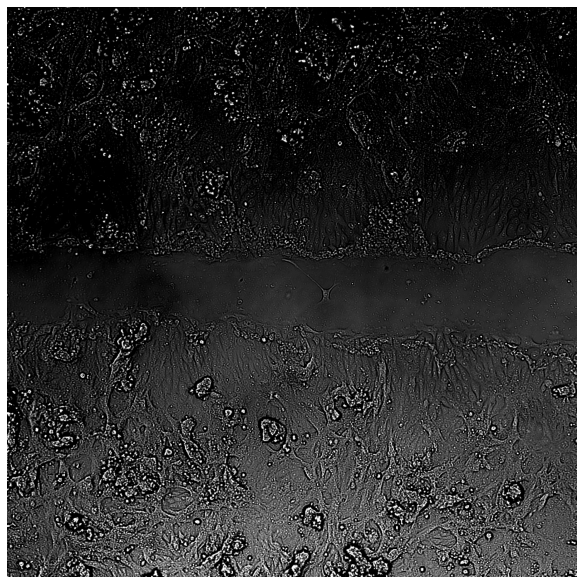

In [3]:
impavi.show('DIC_SN_15_L38_Sum16.tif')

## State of the Art algorithms results

The top 3 Algortithms really struggle with this one.

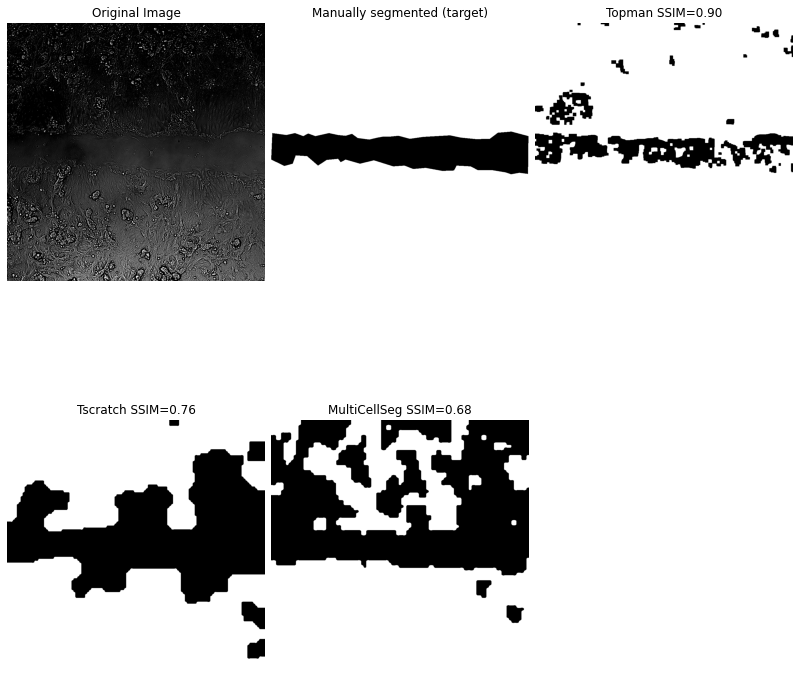

In [4]:
impavi.state_of_the_art('DIC_SN_15_L38_Sum16')

# Equalization 


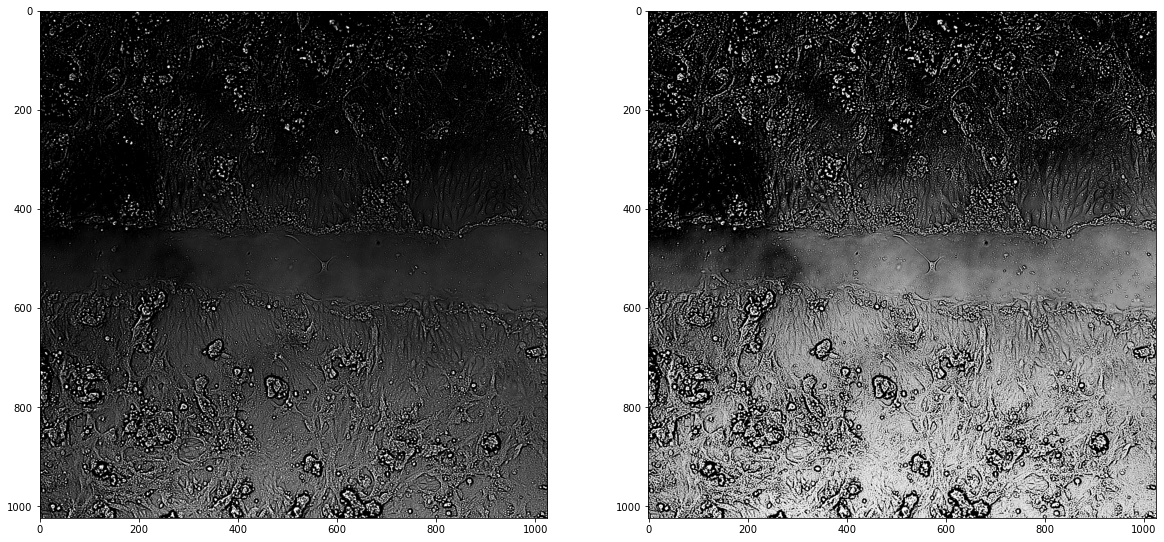

In [5]:
im = plt.imread('DIC_SN_15_L38_Sum16.tif')
im_eq = impavi.equalize(im,plot=False)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.imshow(im_eq,cmap='gray')

# High pass filter aproach

As in the first notebook, one possible approach is to try to retain the parts of the image with high detail. In other words, gather information aboout change of contrast, edges, shapes, etc. This can be achieved by applying a "high pass filter" to the Fourier Transform of the image. Varying the radius of the sharp cut-off filter we can obtain different results. The best one is obtained by using a radius of 0.005 and the image is shown below.

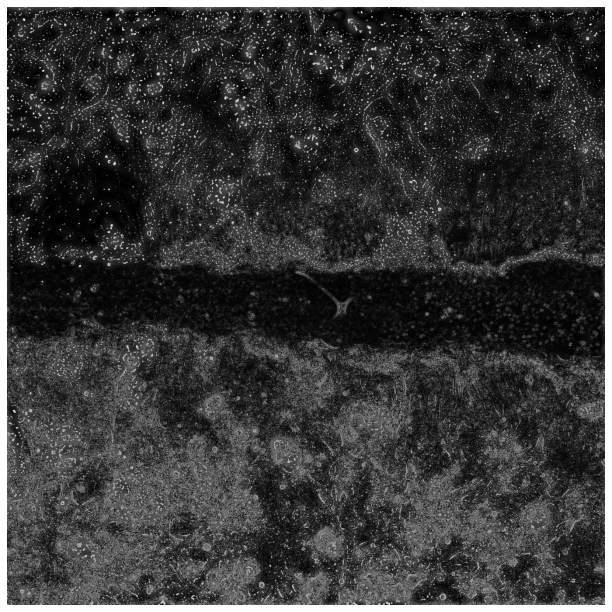

In [7]:
#Fast Fourier Transform
im_tf = np.fft.fftshift(np.fft.fft2(im_eq))
#build Laplacian Filter 
u, v = np.meshgrid(np.linspace(-1, 1, im.shape[0]), np.linspace(-1, 1, im.shape[1]))
lf = u**2 + v**2
circ = lf>0.005

im1 = np.abs(np.fft.ifft2(im_tf*circ))

plt.figure(figsize=(11,11))
plt.axis('off')
plt.imshow(im1,cmap='gray')

I proceed to average the image with a very specific filter. That is, a rectangular filter with a higher dimension along the horizontal axis. This will minimize the loss of information at the edges of the cut and will get rid of the noise (white spots) on the cut region. 

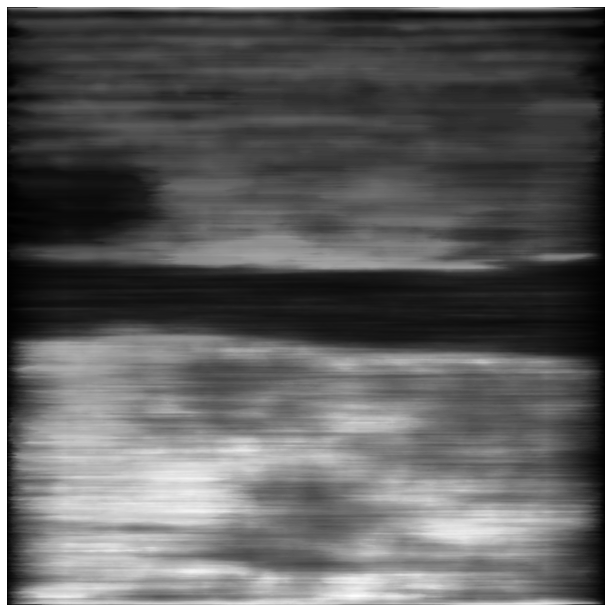

In [9]:
media = scipy.signal.medfilt2d(im1, kernel_size=[3,201])
plt.figure(figsize=(11,11))
plt.axis('off')
plt.imshow(media,cmap='gray')

To obtain the final result, I proceed to binarize the image and apply two more median filters.

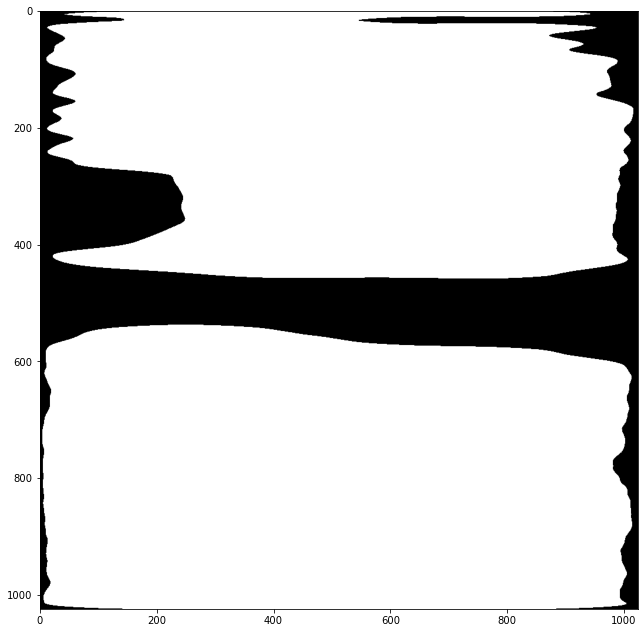

In [10]:
final = (media>0.04).astype(float)
media = scipy.signal.medfilt2d(final, kernel_size=[11,201])

media2 = scipy.signal.medfilt2d(media, kernel_size=[11,201])
plt.figure(figsize=(11,11))
plt.imshow(media2,cmap='gray')

This time, a low-pass filter allows us to eliminate noise and smooth the result. Note that this is the complementary filter to the one previously used (the effect obtained is opposite). 

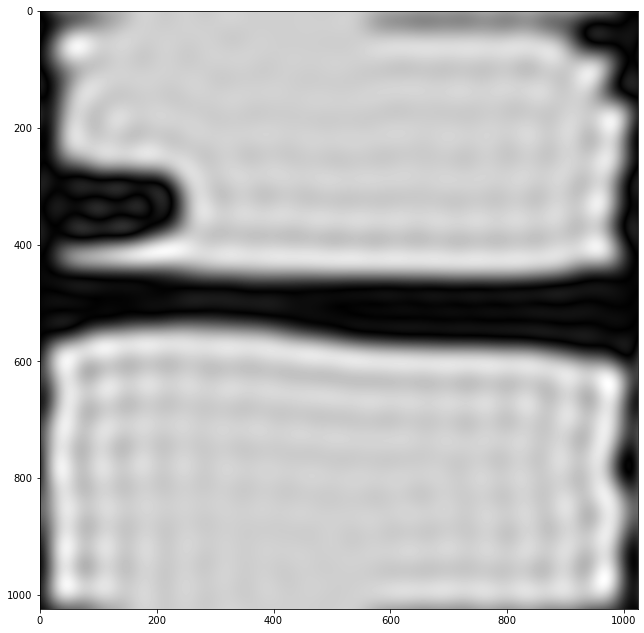

In [11]:
#Fast Fourier Transform
im_tf = np.fft.fftshift(np.fft.fft2(media2))
#build Laplacian Filter 
u, v = np.meshgrid(np.linspace(-1, 1, im.shape[0]), np.linspace(-1, 1, im.shape[1]))
lf = u**2 + v**2
circ = lf<0.0009

im1 = np.abs(np.fft.ifft2(im_tf*circ))

plt.figure(figsize=(11,11))
plt.imshow(im1,cmap='gray')

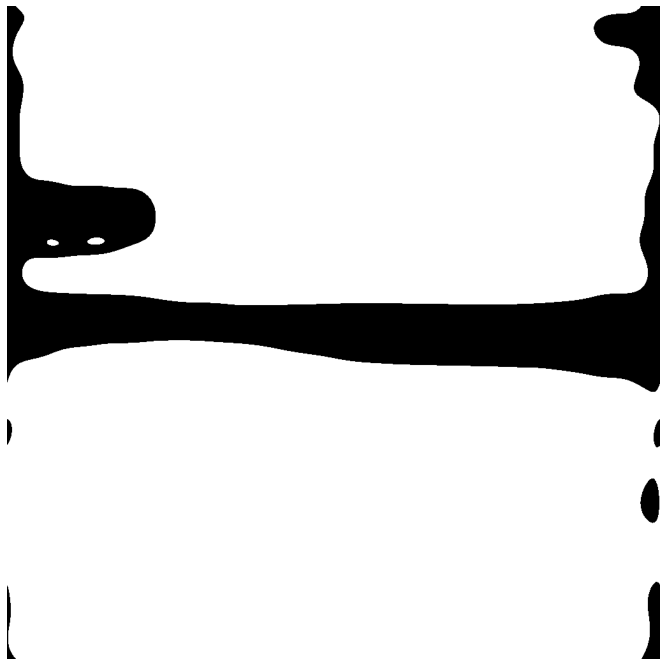

In [12]:
final = im1>0.2
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(final,cmap='gray')

## SSIM of my result and of all the other algorithms

I finally proceed to compare the result obtained with the solution built manually provided in the dataset. 

In [10]:
target = plt.imread('DIC_SN_15_L38_Sum16_manual.png')
ssim = skimage.metrics.structural_similarity(target,final)
print('The SSIM between the target and my result is:',ssim)

The SSIM between the target and my result is: 0.9086286163314615


/Users/codefrom0/opt/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:293: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


The next function computes SSIM between the target and also of all possible combinations between my result and the state of the art algorithms' results. This provides a correlation matrix that can be represented with highly visual information about the performance of each one of the results.

/Users/codefrom0/opt/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:293: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


<AxesSubplot:>

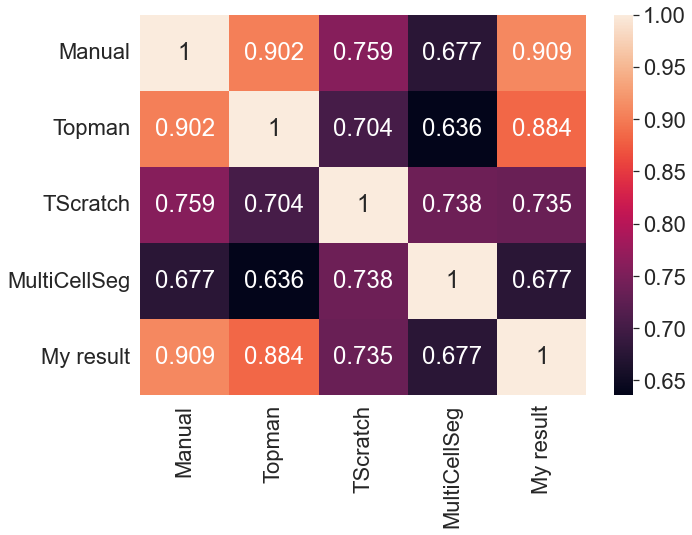

In [13]:
ssim = impavi.ssim_matrix('DIC_SN_15_L38_Sum16',final)
import seaborn as sn
import pandas as pd

sn.set(font_scale=2)

df_cm = pd.DataFrame(ssim, index = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']],
                  columns = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.3g',)